In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from astropy.io import fits
sns.set_context('talk')
plt.style.use('default')
from warnings import filterwarnings
filterwarnings('ignore')
from astropy.wcs import wcs
from time import sleep
import statistics
from scipy.stats import skew # calculates skewness of gaussian
from scipy.stats import skewnorm

clump = 1

In [3]:
# define functions
def open_file(path, val_name):
    # get correct file name
    if val_name == 'column_density':
        print("opening files for path...", path)
        file = 'bantot'
    elif val_name == 'column_density_err':
        file = 'bantot_err'
    elif val_name == 'hf':
        file = 'NH3_1-1_hf_width'
    elif val_name == 'hf_err':
        file = 'NH3_1-1_hf_width_err'
        
    hdul = fits.open('D:/hf_vel/'+path+'_'+file+'.fits')
    hdr = hdul[0].header
    hdr.set('BLANCK', 'none') # idk why blanck = -1 originally 
    hdr.set('NAXIS3',1) #i get an error message when this is gone idk
    d = hdul[0].data #3D with 2 channels ?
    data = np.swapaxes(d,0,2)
    hdul.close()
    coords = []
    values = []
    for (i, j, k), value in np.ndenumerate(data):
        coords.append((i, j, k))
        values.append(value)
    df = pd.DataFrame({'Coordinate': coords, 'Value': values})
    df[['X', 'Y', 'Z']] = pd.DataFrame(df['Coordinate'].tolist(), index=df.index)
    df = df.drop('Coordinate', axis=1)
    df = df.drop(columns = 'Z')
    
    # renaming value to correct name
    df.rename(columns = {'Value':val_name}, inplace = True)
    return df

def weighted_average(values):
    skewness = skew(values)
    pdf_values = skewnorm.pdf(values, skewness)
    # Normalize the PDF values so that they sum up to 1
    pdf_values /= np.sum(pdf_values)
    
    # returns the normalized weighted average for a list of values
    return np.sum(values * pdf_values)

In [4]:
# load csv and store as a df
first_half = pd.read_csv("D:/clump_designations/df_designations.csv")
second_half = pd.read_csv("D:/clump_designations/cutoff.csv")
clump_designations = pd.concat([first_half, second_half], ignore_index = True)

# removing value column 
clump_df = clump_designations.drop(columns=['Value'])

In [5]:
# define regions and clump total
paths = ['L43','L41','L40_5','L40','L39_5','L39','L38_5','L38','L37_5',
          'L37','L36_5','L36','L35_5','L34_5','L34','L33_5','L33','L32_5'
          ,'L32','L31_5','L31','L30_5','L30','L29_5','L29','L28_5','L28','L27_5'
          ,'L27','L26_5','L26','L25_5','L25','L24_5','L24','L23_5','L23','L22_5'
          ,'L22','L21_5','L21','L20_5','L19','L18_5','L18','L17_5','L17',
          'L16_5','L15_5','L15','L14_5','L14','L13_5','L13','L12_5','L12',
          'L11_5','L11','L10_5','L10']
# removed: L47 L35 L20 L19_5
final_n = [16,6,7,5,6,23,26,26,26,26,42,62,40,
                41,3,25,19,15,69,50,93,89,93,80,39,92,60,40,30
                ,98,35,39,88,80,93,92,99,9,6,17,19,11,74,
                49,2,5,33,41,8,60,60,40,35,35,50,30,18,40,40,20]
# removed: 6 41 16 84
obj = list(zip(paths,final_n))

# avg clump data 
avg_clump_data = pd.DataFrame()

for item in obj:
    # get the column density and error for each value
    col_density = open_file(item[0], 'column_density').dropna()
    col_density_err = open_file(item[0], 'column_density_err').dropna()
    hf = open_file(item[0], 'hf').dropna()
    hf_err = open_file(item[0], 'hf_err').dropna()
    
    # merge dataframes on XY
    merge1 = pd.merge(col_density, col_density_err, on=['X', 'Y'])
    merge2 = pd.merge(merge1, hf, on=['X', 'Y'])
    merged_data = pd.merge(merge2, hf_err, on =['X', 'Y'])

    # get rid of nan rows
    Data = merged_data.dropna()

    Data = Data[['X', 'Y', 'column_density', 'column_density_err', 'hf', 'hf_err']]
    
    # get rows of clump_designations corresponding to current item[0]
    current_region = clump_df[clump_df['Region'] == item[0]]

    for i in range(1,item[1]+1):
        # get current data to work with
        current_clump = current_region[current_region['Cluster'] == i]
    
        current_data = pd.merge(current_clump, Data, on =['X', 'Y'])
     
        # get data to list
        cd_vals = current_data['column_density'].tolist()
        cd_err_vals = current_data['column_density_err'].tolist()
        hf_vals = current_data['hf'].tolist()
        hf_err_vals = current_data['hf_err'].tolist()
        
        # compute weighted average of skewed distribution
        avg_cd = weighted_average(cd_vals)
        avg_cd_err = weighted_average(cd_err_vals)
        avg_hf = weighted_average(hf_vals)
        avg_hf_err = weighted_average(hf_err_vals)
        
        # put in dataframe
        avgs = {'region':item[0],'clump':clump,
                'avg_cd': avg_cd,'avg_cd_err': avg_cd_err,
                'avg_hf': avg_hf, 'avg_hf_err': avg_hf_err}
        
        # concat row to big dataframe
        d = pd.DataFrame(avgs, index=[0])
        
        if not (d == 0).any(axis=1).bool():
            avg_clump_data = pd.concat([avg_clump_data, d], ignore_index = True)
        clump += 1
        
    print("Region", item[0], "complete")
    print(len(avg_clump_data), "total clumps")

opening files for path... L43
Region L43 complete
4 total clumps
opening files for path... L41
Region L41 complete
9 total clumps
opening files for path... L40_5
Region L40_5 complete
12 total clumps
opening files for path... L40
Region L40 complete
14 total clumps
opening files for path... L39_5
Region L39_5 complete
16 total clumps
opening files for path... L39
Region L39 complete
22 total clumps
opening files for path... L38_5
Region L38_5 complete
31 total clumps
opening files for path... L38
Region L38 complete
42 total clumps
opening files for path... L37_5
Region L37_5 complete
53 total clumps
opening files for path... L37
Region L37 complete
63 total clumps
opening files for path... L36_5
Region L36_5 complete
72 total clumps
opening files for path... L36
Region L36 complete
94 total clumps
opening files for path... L35_5
Region L35_5 complete
114 total clumps
opening files for path... L34_5
Region L34_5 complete
134 total clumps
opening files for path... L34
Region L34 complet

In [6]:
print(avg_clump_data)

     region  clump     avg_cd  avg_cd_err    avg_hf  avg_hf_err
0       L43      4  13.847732    0.134629  0.709948    0.061529
1       L43      8  13.905041    0.196598  1.604934    0.345179
2       L43     10  13.911025    0.239067  1.791867    0.197179
3       L43     12  13.978198    0.100979  0.487115    0.033152
4       L41     17  14.047061    0.266672  0.965224    0.115213
...     ...    ...        ...         ...       ...         ...
1430    L10   2467  14.371370    0.134577  0.834901    0.072681
1431    L10   2470  14.199109    0.127169  0.914794    0.071371
1432    L10   2471  14.010212    0.127426  0.794500    0.083188
1433    L10   2472  14.395441    0.229819  1.030964    0.097465
1434    L10   2473  14.118745    0.136359  0.804079    0.103384

[1435 rows x 6 columns]


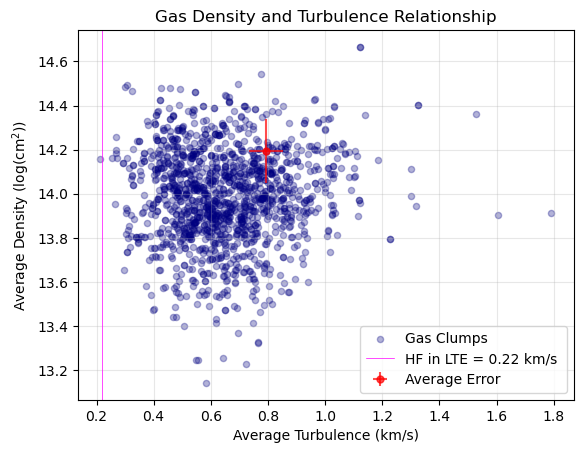

In [96]:
filtered_df = avg_clump_data[avg_clump_data['avg_cd'] > 1]

# get data
col_log = filtered_df['avg_cd'].tolist() # log(cm^2)

hf = filtered_df['avg_hf'].tolist() # in km/s

# getting errors
col_err_log = filtered_df['avg_cd_err'].tolist() # error in log(cm^2)
hf_err = filtered_df['avg_hf_err'].tolist() # in km/s

# Calculate average errors
avg_hf_error = np.mean(hf_err)
avg_col_error = np.mean(col_err_log)

# getting region designations as int
region = filtered_df['region'].tolist() # gets region designation 
number_list = [int(s[1:]) for s in region] # turn region name into num

# plot data
plt.scatter(hf,col_log, alpha = 0.3, color = 'navy', s=20, label ='Gas Clumps')

plt.errorbar(hf[400], col_log[400], xerr=avg_hf_error, yerr=avg_col_error, fmt='o',alpha = 0.7, color='red', markersize=5, label='Average Error')
plt.axvline(x = 0.22, color = 'magenta',lw=0.5, label = 'HF in LTE = 0.22 km/s ')

plt.title("Gas Density and Turbulence Relationship")
plt.xlabel("Average Turbulence (km/s)")
plt.ylabel("Average Density (log(cm$^2$))")
plt.legend()
plt.grid()
plt.grid(alpha=0.3)
plt.savefig('D:result.png')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


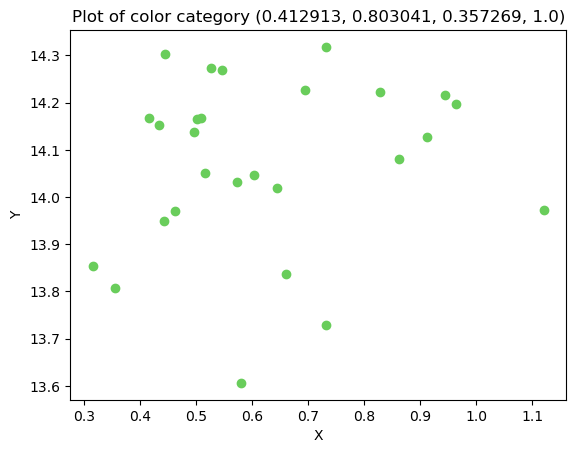

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


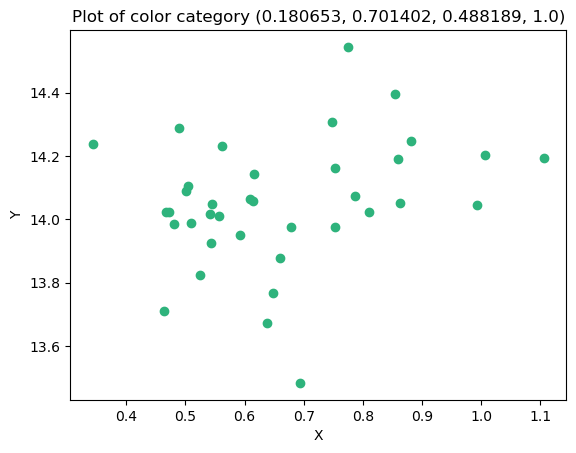

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


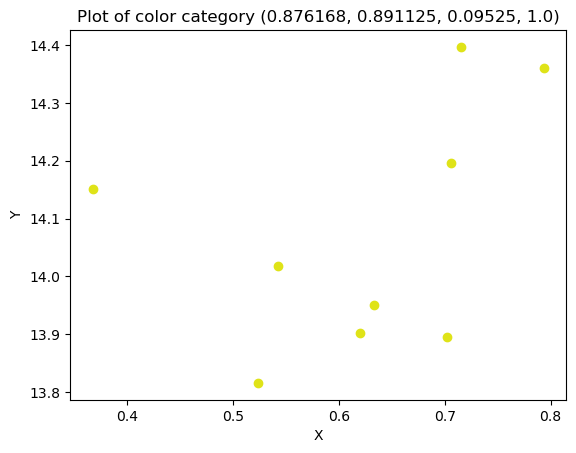

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


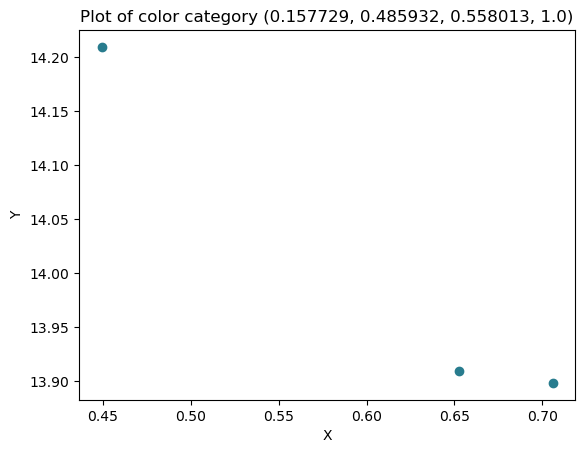

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


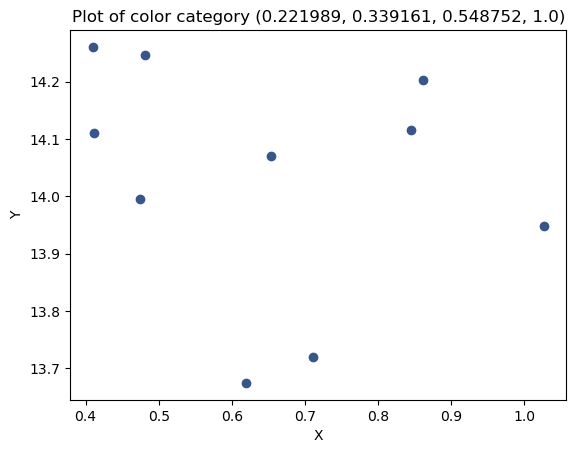

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


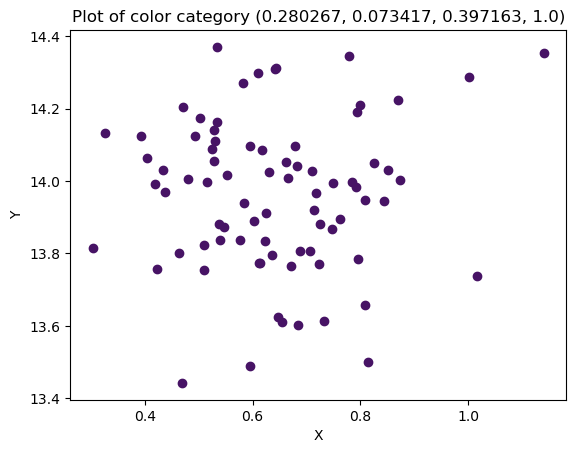

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


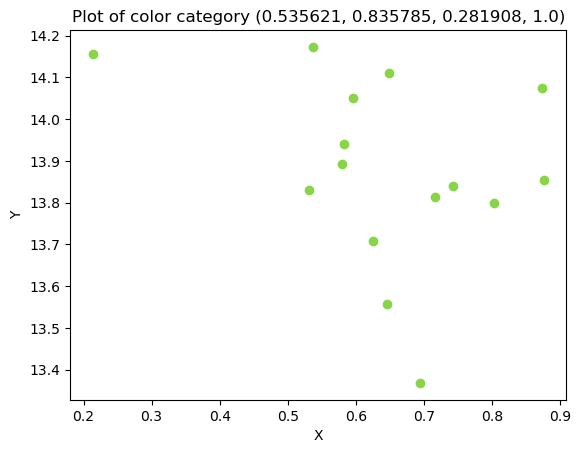

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


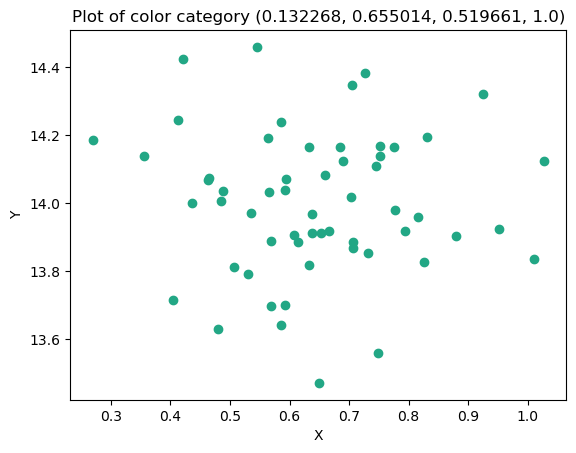

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


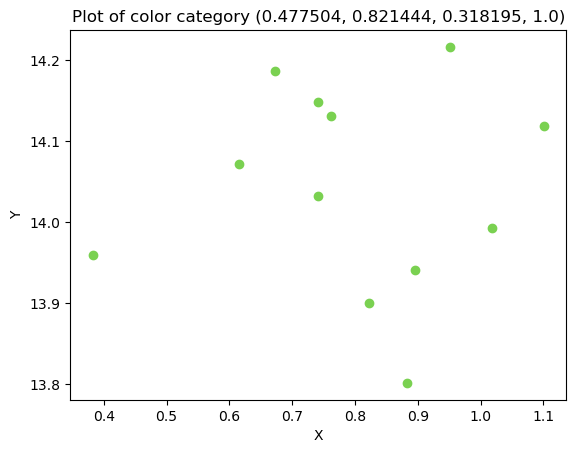

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


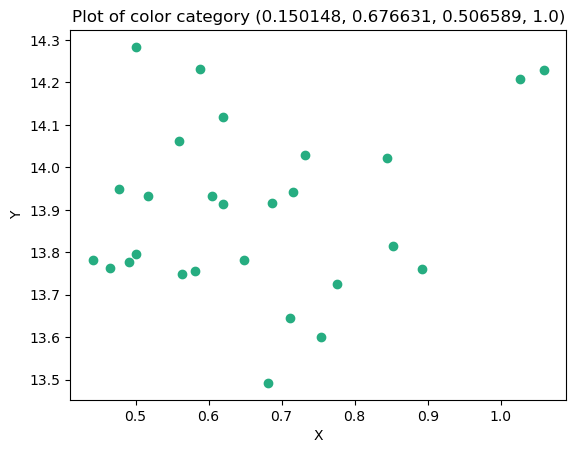

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


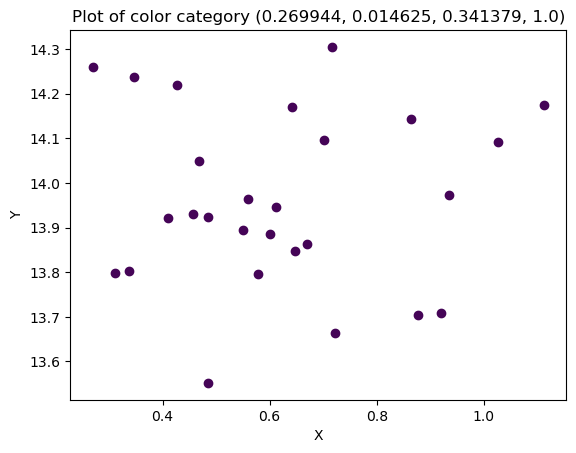

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


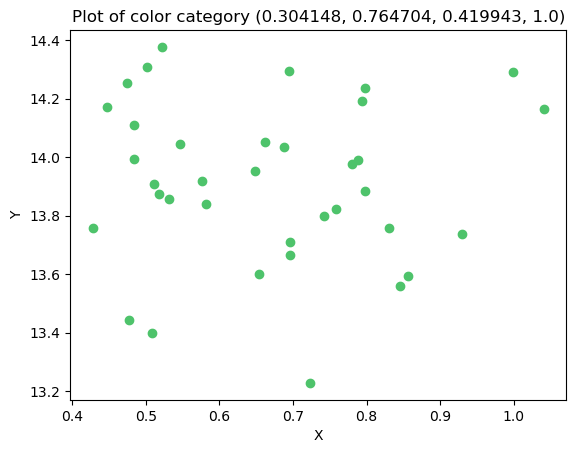

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


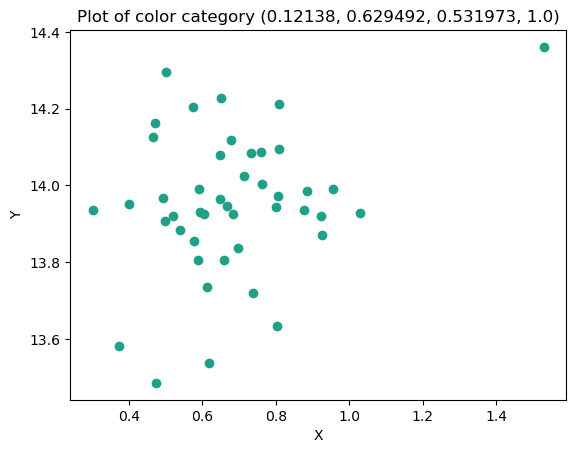

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


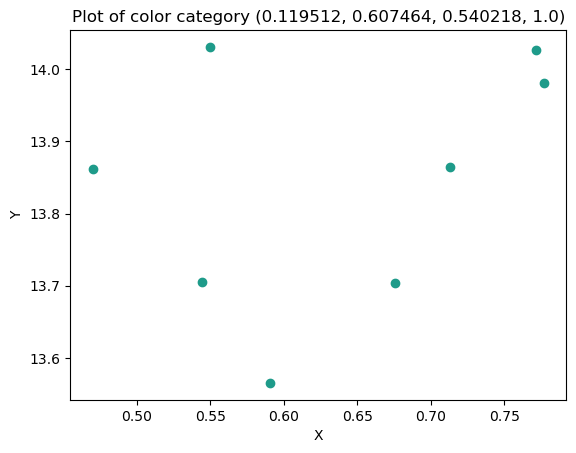

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


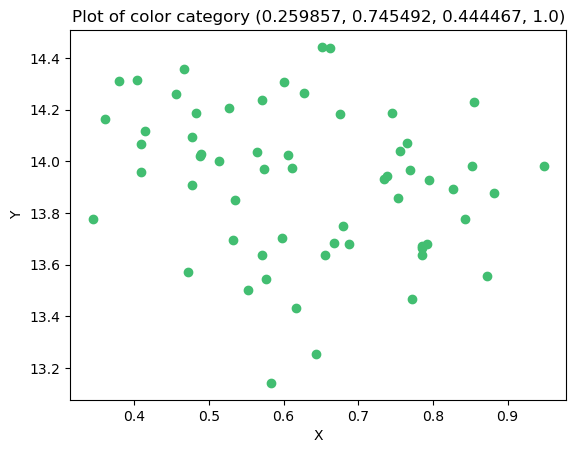

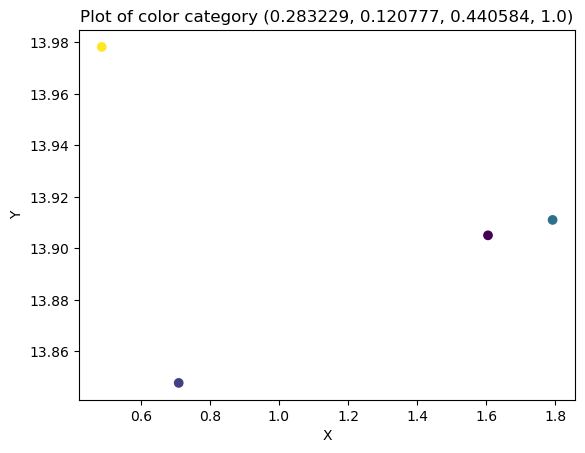

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


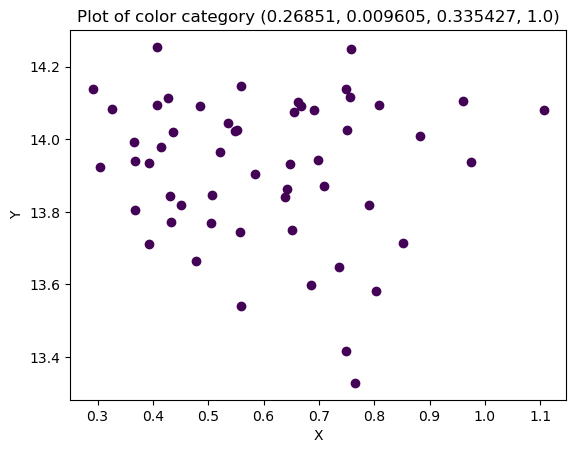

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


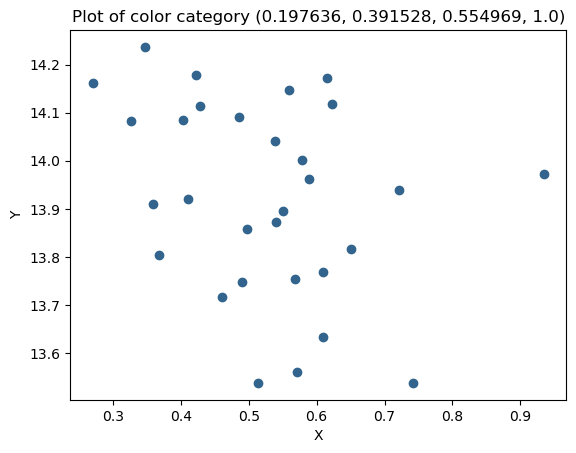

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


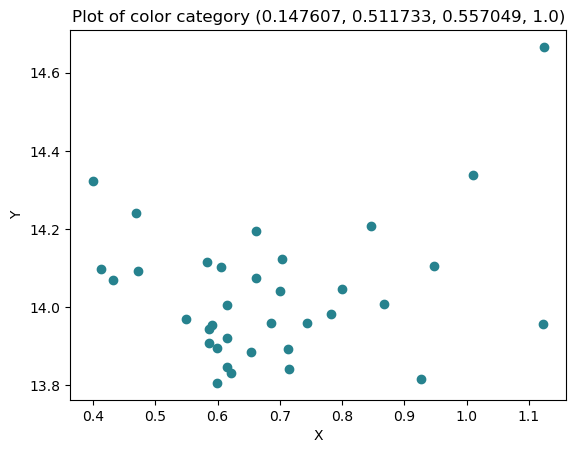

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


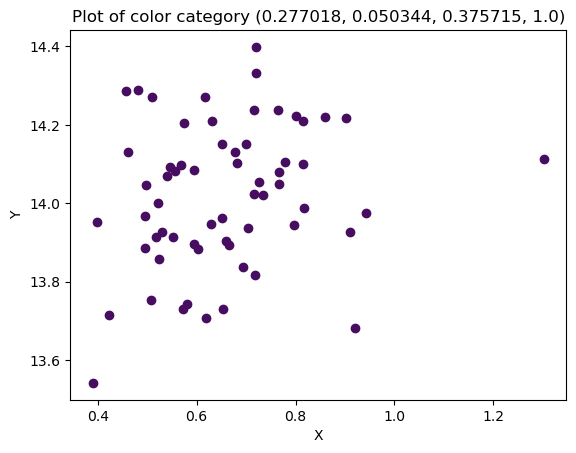

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


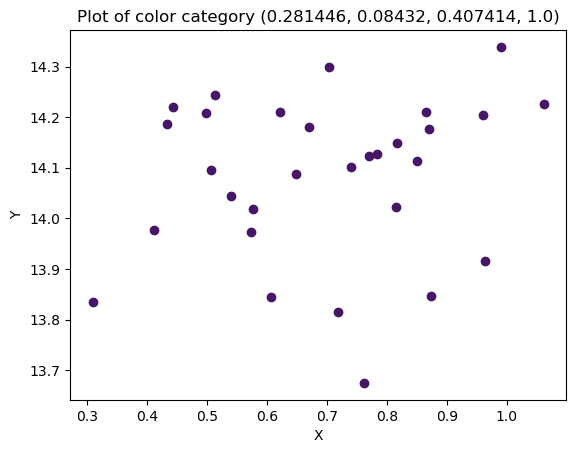

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


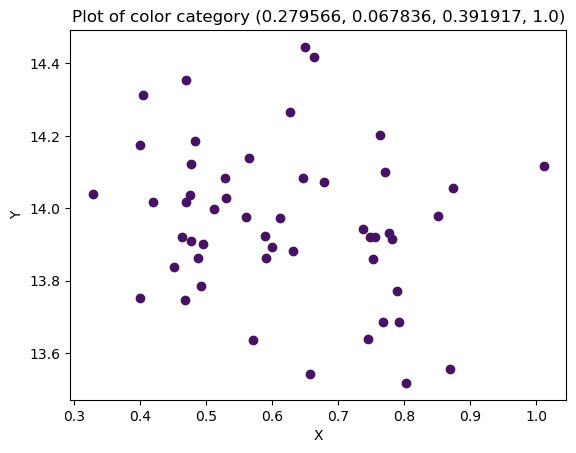

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


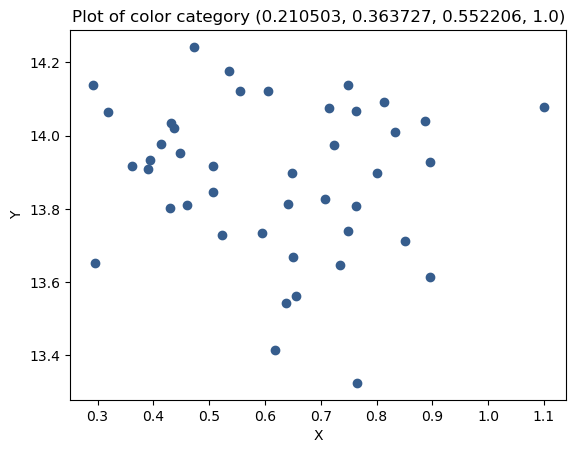

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


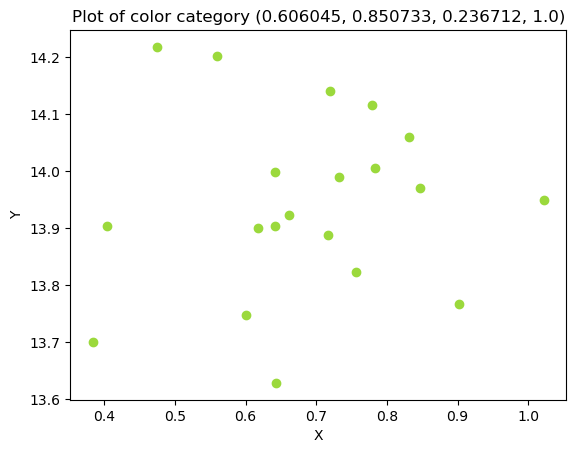

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


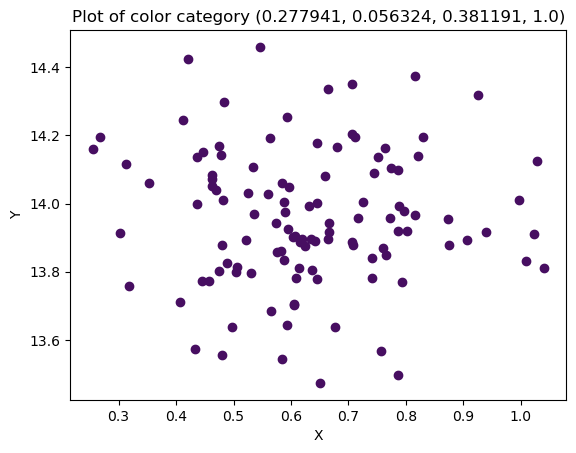

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


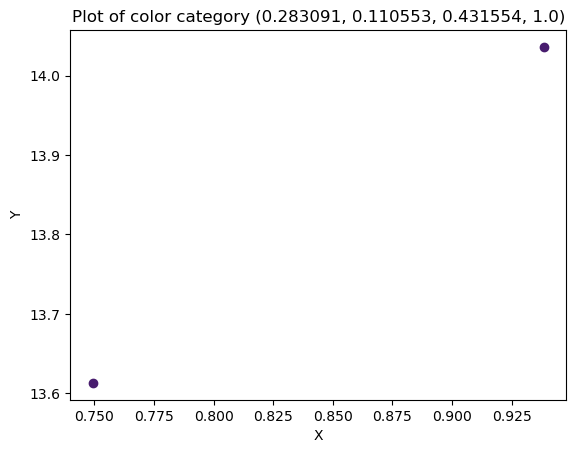

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


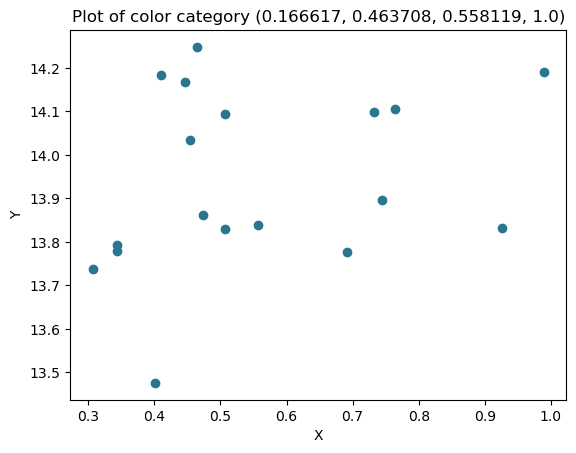

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


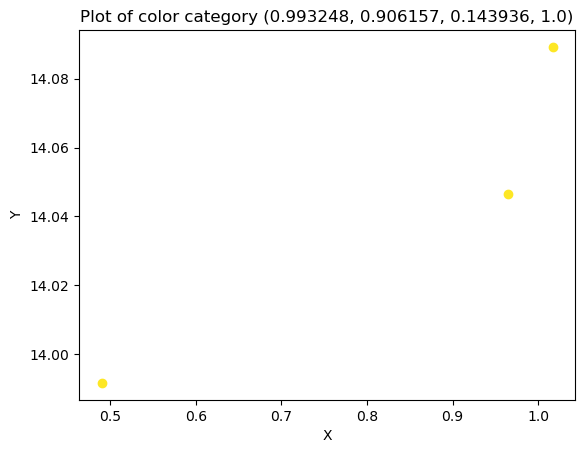

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


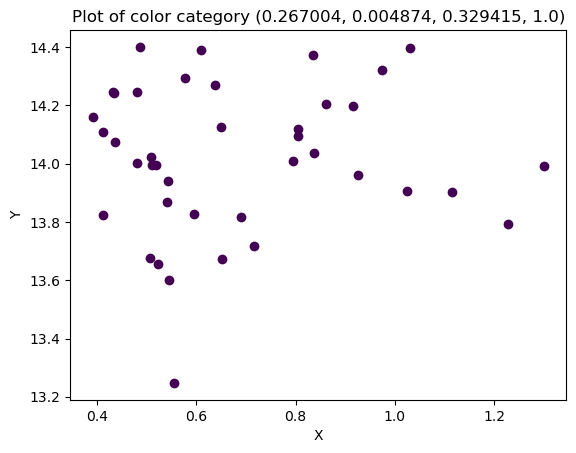

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


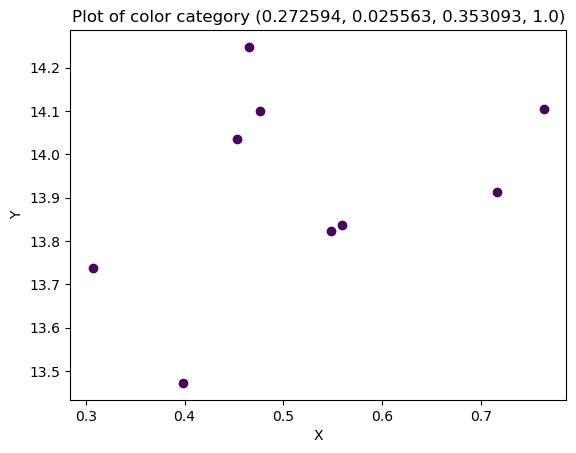

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


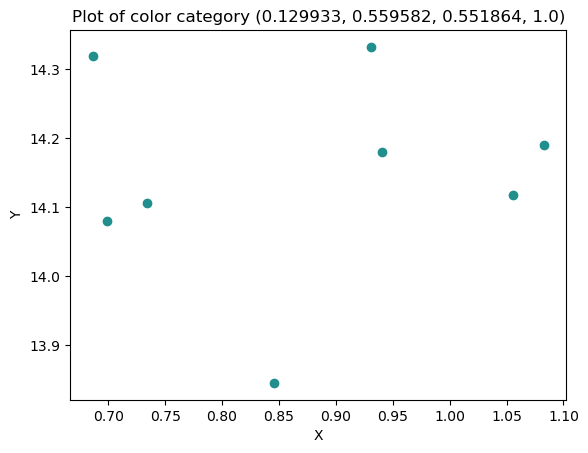

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


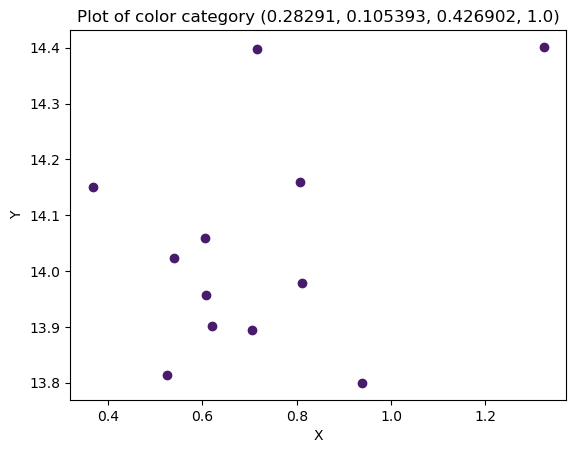

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


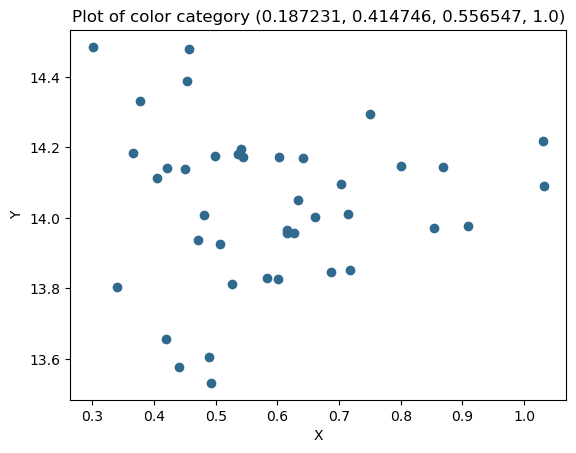

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


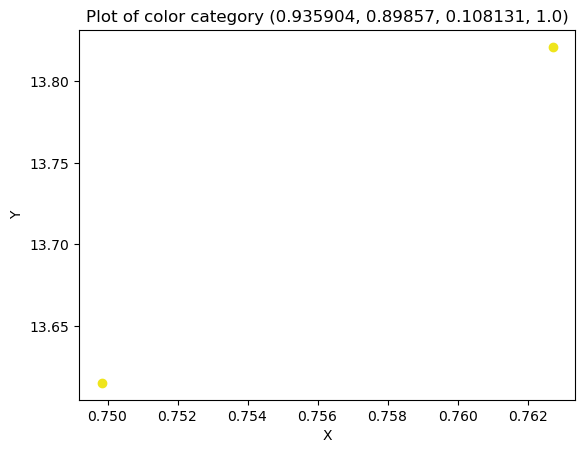

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


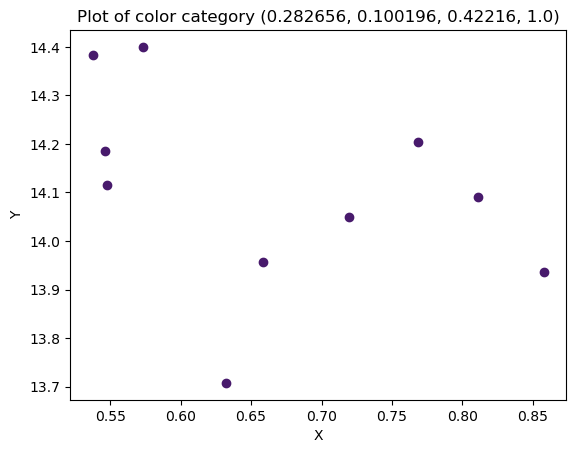

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


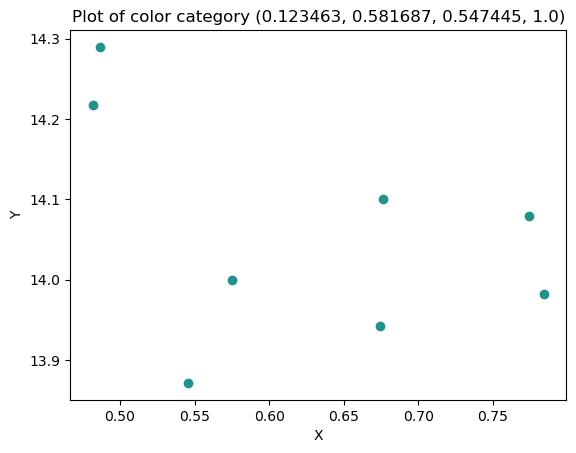

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


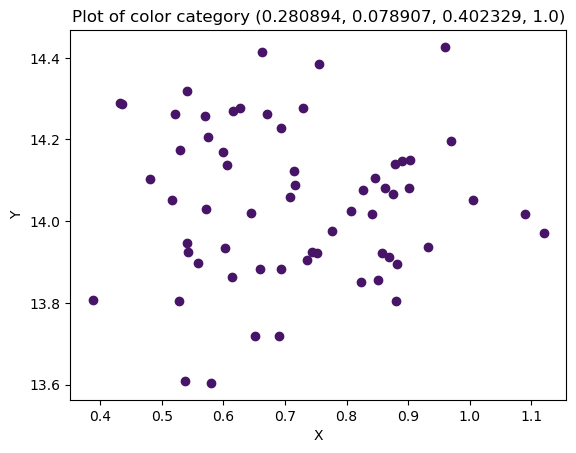

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


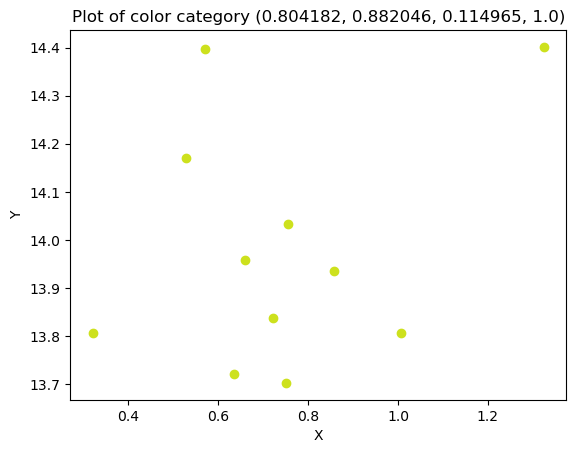

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


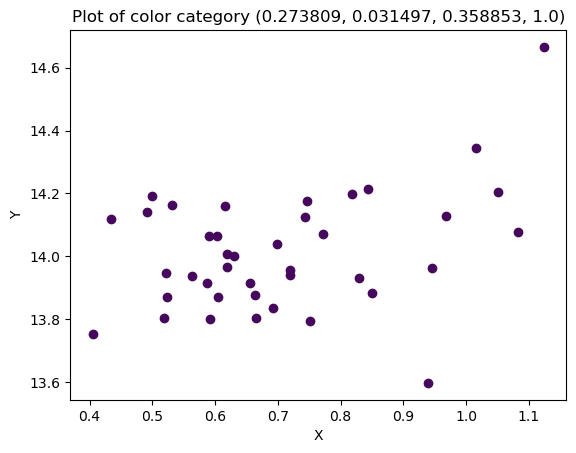

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


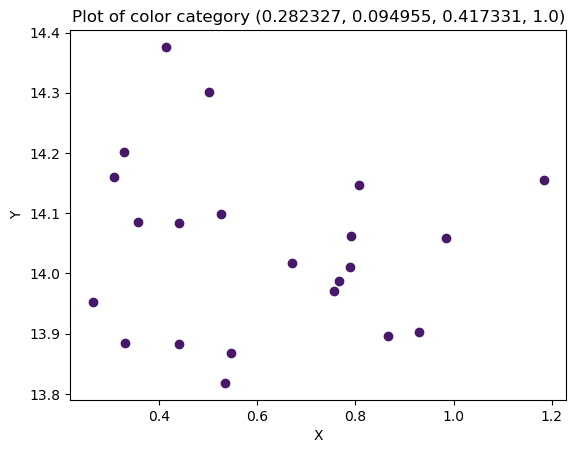

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


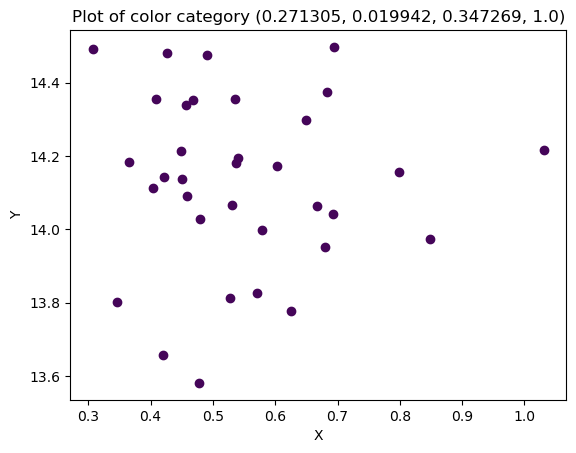

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


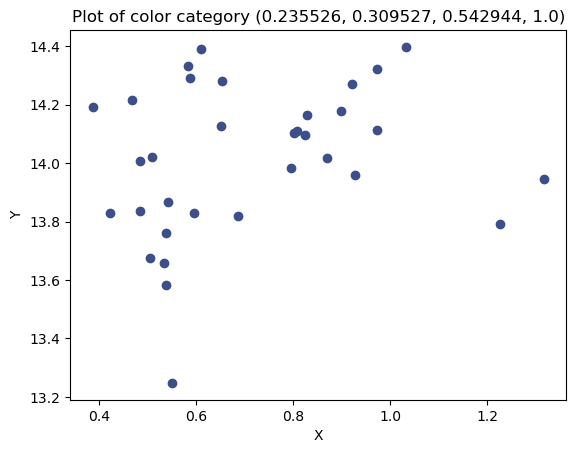

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


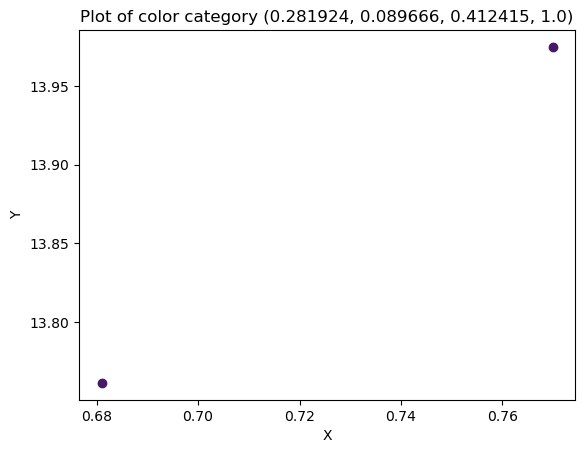

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


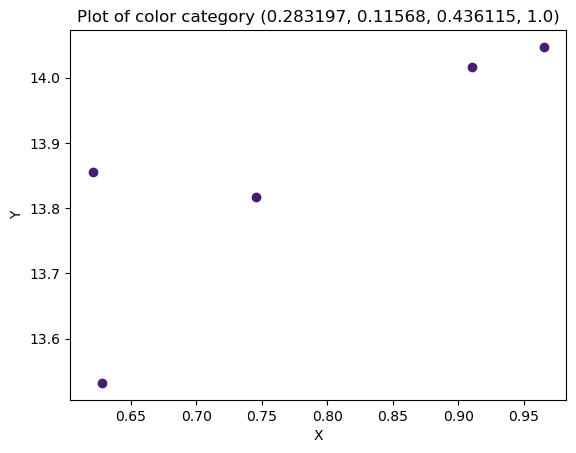

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


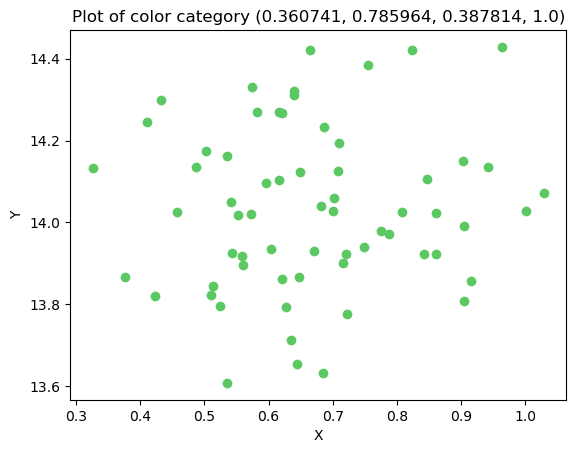

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


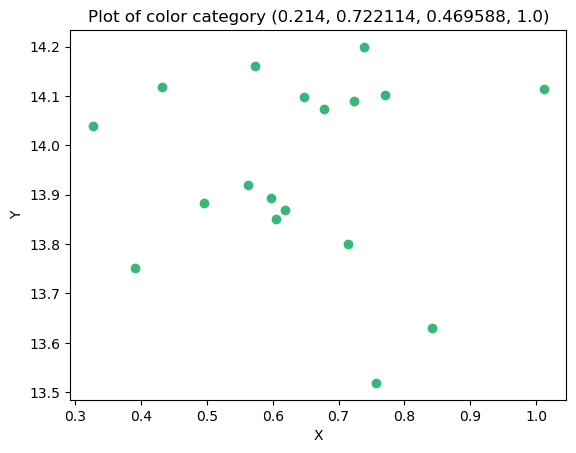

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


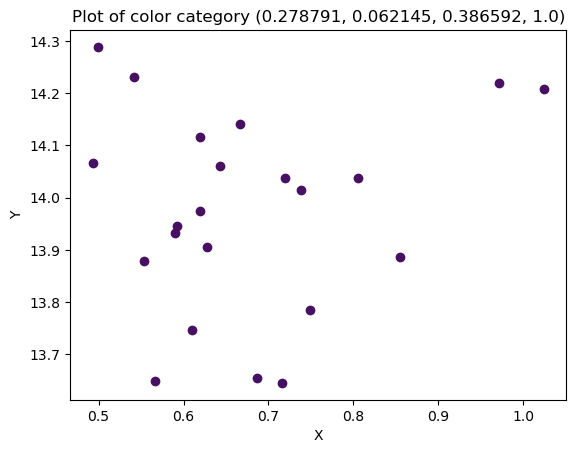

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


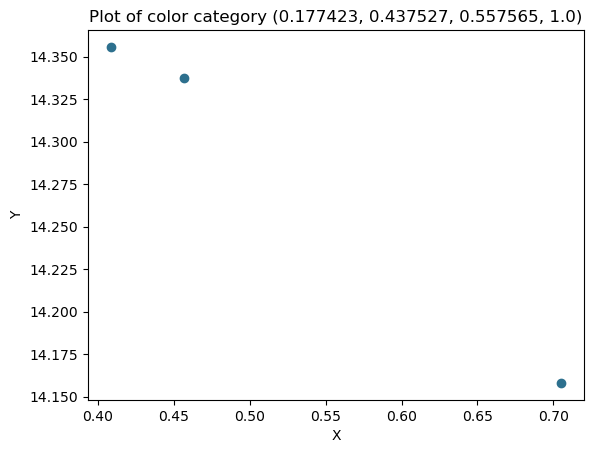

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


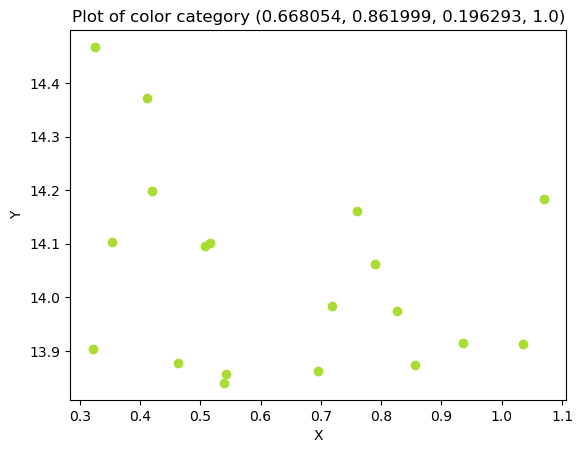

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


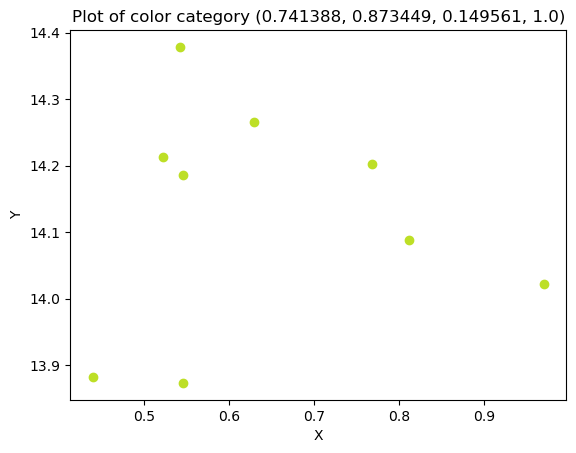

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


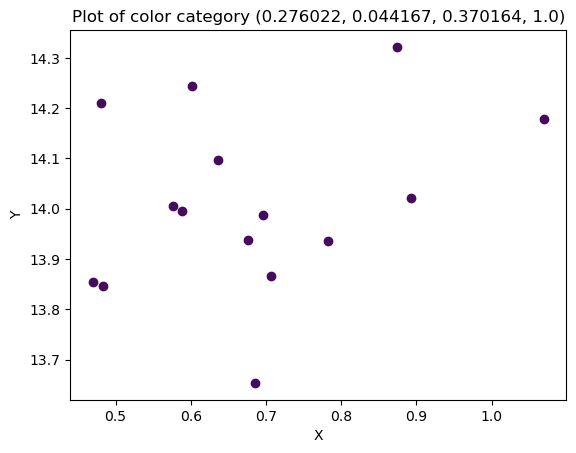

In [17]:
# Iterate through each color category
unique_colors = set(colors)  # Get unique colors

for selected_color in unique_colors:
    selected_indices = [i for i, color in enumerate(colors) if color == selected_color]

    filtered_x = [hf[i] for i in selected_indices]
    filtered_y = [col[i] for i in selected_indices]

    plt.scatter(filtered_x, filtered_y, c=selected_color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Plot of color category {selected_color}')
    plt.show()

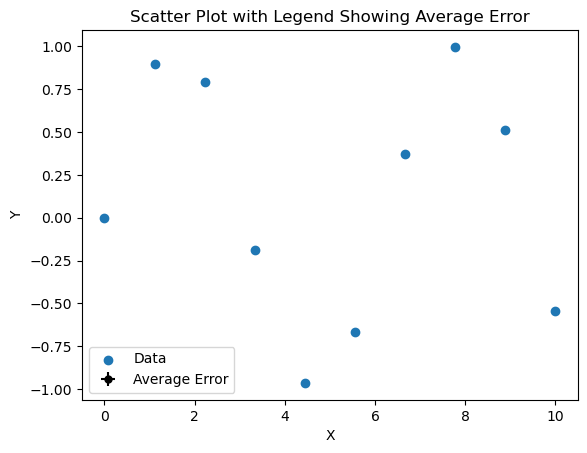

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0, 10, 10)
y = np.sin(x)
x_errors = np.random.rand(10)
y_errors = np.random.rand(10)

# Calculate average errors
avg_x_error = np.mean(x_errors)
avg_y_error = np.mean(y_errors)

# Plot the data
plt.scatter(x, y, label='Data')

# Create custom legend entry for average error
plt.errorbar([
], [], xerr=avg_x_error, yerr=avg_y_error, fmt='o', color='black', markersize=5, label='Average Error')

# Add legend
plt.legend()

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with Legend Showing Average Error')
plt.show()

